In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler, ADASYN
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(10, 10)})

In [2]:
df_main = pd.read_csv('../full_adult_clean.csv')
labels = pd.read_csv('../adult_labels.csv')
# df_main.head()
df_main.info()
# read clean data + labels previously saved in KNN lab#

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46033 entries, 0 to 46032
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   age                           46033 non-null  int64
 1   educational-num               46033 non-null  int64
 2   gender                        46033 non-null  int64
 3   capital-gain                  46033 non-null  int64
 4   capital-loss                  46033 non-null  int64
 5   hours-per-week                46033 non-null  int64
 6   workclass_Federal-gov         46033 non-null  int64
 7   workclass_Local-gov           46033 non-null  int64
 8   workclass_Private             46033 non-null  int64
 9   workclass_Self-emp-inc        46033 non-null  int64
 10  workclass_Self-emp-not-inc    46033 non-null  int64
 11  workclass_State-gov           46033 non-null  int64
 12  occupation_Adm-clerical       46033 non-null  int64
 13  occupation_Craft-repair       4

In [3]:
def print_results(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))
    print('F1-score:', f1_score(y_true, y_pred))
    print('precision-score:', precision_score(y_true, y_pred))
    print('recall-score:', recall_score(y_true, y_pred))
    print('roc_auc-score:', roc_auc_score(y_true, y_pred))
labels.value_counts(normalize=True)

is_income_over_50k
0                     0.751874
1                     0.248126
dtype: float64

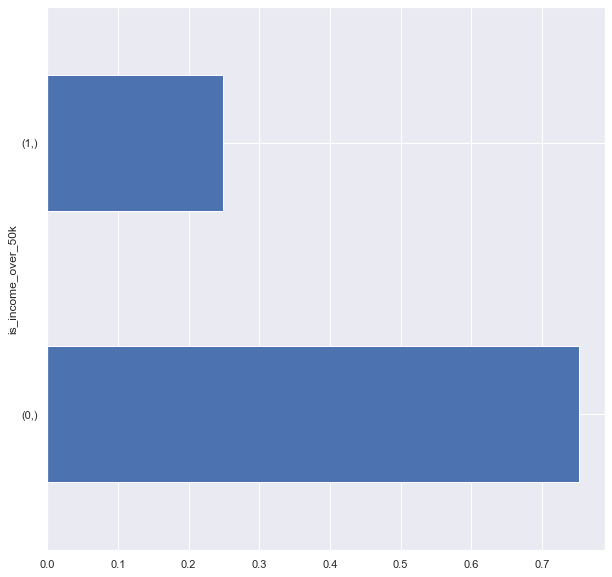

In [15]:
labels.value_counts(normalize=True).plot(kind='barh')
plt.show()
# not balanced data

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data = scaler.fit_transform(df_main)
X_train, X_valid, y_train, y_valid = train_test_split(data, labels, 
                                             test_size=0.3, random_state=2021) 

In [5]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
w = log_reg.coef_
bb = log_reg.intercept_
print(w, bb)
# default params LR

[[ 0.34040339  0.69131424  0.09347763  2.42325338  0.2670959   0.32626087
   0.17191986  0.10086974  0.24210457  0.1414349   0.00726381  0.04714145
  -0.16397484 -0.146635    0.1018261  -0.27380811 -0.22785756 -0.19879062
  -0.39878958 -0.19344066  0.02474139 -0.0099785  -0.07102648  0.02184806
  -0.14151841  1.12531588 -0.38254131  0.06489517  0.09079613]] [-1.84801109]


In [18]:
y_pred = log_reg.predict(X_valid)
print_results(y_valid, y_pred)

[[9641  684]
 [1386 2099]]
F1-score: 0.6697511167836631
precision-score: 0.7542220625224578
recall-score: 0.6022955523672884
roc_auc-score: 0.7680242895008355


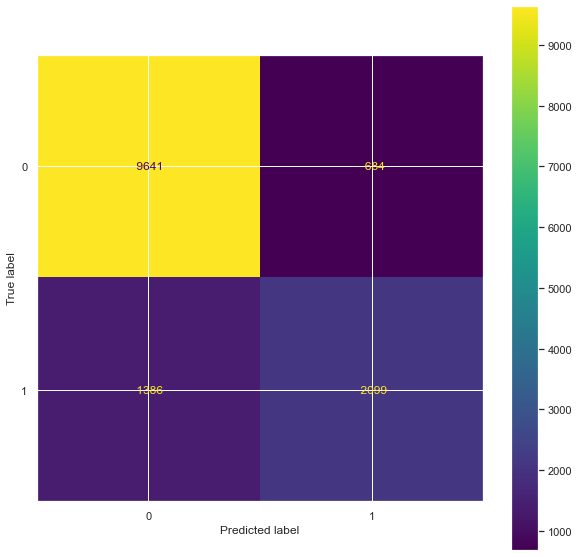

In [19]:
plot_confusion_matrix(log_reg, X_valid, y_valid, values_format='5g')
plt.show()

In [20]:
log_reg = LogisticRegression(solver='liblinear')
C_values = {'C': np.logspace(-3, 3, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)
# inverse reularization strength search

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03])},
             scoring='f1')

In [21]:
print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 0.46415888336127775}
0.6514681120886218


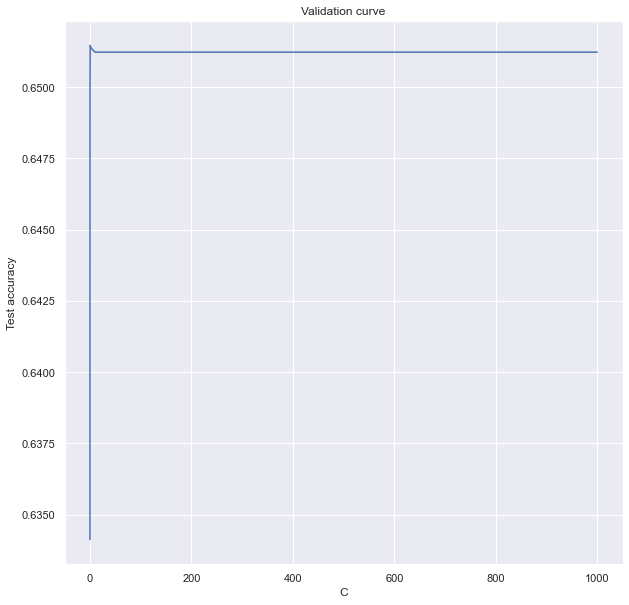

In [22]:
results_df = pd.DataFrame(logreg_grid.cv_results_)
plt.plot(results_df['param_C'], results_df['mean_test_score'])

plt.xlabel('C')
plt.ylabel('Test accuracy')
plt.title('Validation curve')
plt.show()

In [23]:
log_reg = LogisticRegression(solver='liblinear', penalty='l1')

C_values = {'C': np.logspace(-3, 3, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)


print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 0.46415888336127775}
0.6516020413965027


In [24]:
log_reg = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5)
#  'saga' fast convergence is only guaranteed on features with approximately the same scale
C_values = {'C': np.logspace(-3, 1, 10)}
logreg_grid = GridSearchCV(log_reg, C_values, cv=5, scoring='f1')
logreg_grid.fit(X_train, y_train)

print(logreg_grid.best_params_)
print(logreg_grid.best_score_)

{'C': 1.2915496650148828}
0.6514186512626161


In [25]:
y_pred = logreg_grid.best_estimator_.predict(X_valid)
f1_score(y_valid, y_pred)

0.6699633115329398

In [46]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X_train, y_train)
print(y_ros.value_counts(normalize=True))

logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(X_ros, y_ros)
y_pred = logreg_ros.predict(X_valid)

print_results(y_valid, y_pred)

is_income_over_50k
0                     0.5
1                     0.5
dtype: float64
[[8224 2101]
 [ 555 2930]]
F1-score: 0.6881164866134335
precision-score: 0.5823891870403498
recall-score: 0.8407460545193687
roc_auc-score: 0.818629685855326


In [6]:
ros = ADASYN()
X_ros_ad, y_ros_ad = ros.fit_resample(X_train, y_train)
print(y_ros_ad.value_counts(normalize=True))

logreg_ros = LogisticRegression(solver='liblinear')
logreg_ros.fit(X_ros_ad, y_ros_ad)
y_pred = logreg_ros.predict(X_valid)

print_results(y_valid, y_pred)

is_income_over_50k
1                     0.503658
0                     0.496342
dtype: float64
[[7713 2612]
 [ 398 3087]]
F1-score: 0.6722560975609757
precision-score: 0.541673977890858
recall-score: 0.8857962697274031
roc_auc-score: 0.8164090307474787


In [47]:
logreg_params = {'C': np.logspace(-3, 3, 10), 'penalty': ['l2', 'l1']}
logreg_grid = GridSearchCV(logreg_ros, logreg_params, cv=5, scoring='f1')
logreg_grid.fit(X_ros, y_ros)

y_pred = logreg_grid.best_estimator_.predict(X_valid)
print_results(y_valid, y_pred)

[[8120 2205]
 [ 514 2971]]
F1-score: 0.6860639649001269
precision-score: 0.5739953632148377
recall-score: 0.8525107604017217
roc_auc-score: 0.8194757191839117


SVM

In [7]:
from sklearn import svm
C = 1.0
model1 = svm.SVC(kernel='linear', C=C)
model1.fit(X_train, y_train)
y_predict = model1.predict(X_valid)
print(recall_score(y_valid, y_predict, average=None))
print(recall_score(y_valid, y_predict))

[0.93288136 0.5974175 ]
0.5974175035868006


In [49]:
C = 0.464
model1 = svm.LinearSVC(C=C, max_iter=10000)
model1.fit(X_train, y_train)
y_predict = model1.predict(X_valid)
print(recall_score(y_valid, y_predict, average=None))
print(recall_score(y_valid, y_predict))

[0.93791768 0.5928264 ]
0.5928263988522238


In [50]:
model1 = svm.SVC(kernel='sigmoid', C=C, max_iter=10000)
model1.fit(X_train, y_train)
y_predict = model1.predict(X_valid)
print(recall_score(y_valid, y_predict, average=None))
print(recall_score(y_valid, y_predict))

[0.85578692 0.54949785]
0.5494978479196556


In [51]:
model1 = svm.SVC(kernel='rbf', gamma=0.7, C=C)
model1.fit(X_train, y_train)
y_predict = model1.predict(X_valid)
print(recall_score(y_valid, y_predict, average=None))

[0.94934625 0.45451937]


In [52]:
model1 = svm.SVC(kernel='poly', degree=3, gamma='auto', C=C)
model1.fit(X_train, y_train)
y_predict = model1.predict(X_valid)
print(recall_score(y_valid, y_predict, average=None))
print(recall_score(y_valid, y_predict))

[0.93501211 0.5687231 ]
0.5687230989956958
